In [22]:
import numpy as np
from scipy import optimize, stats
from matplotlib import pyplot as plt

# Toy problem

Assume we have a set of points $(x, y)$ with Gaussian errors on $y$. We fit them with a quadratic function,
but assume that the quadratic term is small (almost linear dependency). We want to provide an exclusion plot
for values of the quadratic coefficient.


In [49]:
a = 0
b = 3
c = 2


def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

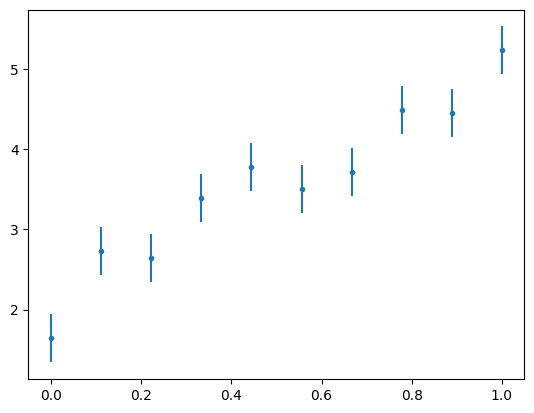

In [50]:
x_data = np.linspace(0, 1, 10)
sigma = 0.3
y_data = quadratic(x_data, a, b, c) + stats.norm.rvs(scale=sigma, size=x_data.size)
y_data_err = sigma * np.ones_like(y_data)

fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, y_data_err, fmt=".")
plt.show()

# Scanning approach

ML fit: a = -0.62 +/- 1.20 (true a = 0)


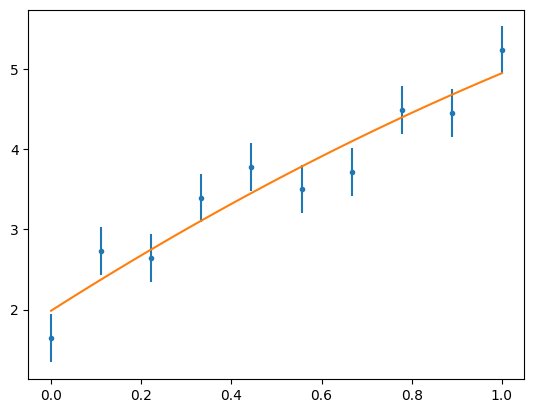

In [51]:
popt, pcov = optimize.curve_fit(
    quadratic,
    x_data,
    y_data,
    sigma=y_data_err,
)
perr = np.sqrt(np.diag(pcov))
a_best_fit = float(popt[0])
a_best_fit_error = float(perr[0])
print(f"ML fit: a = {a_best_fit:.2f} +/- {a_best_fit_error:.2f} (true a = {a})")

fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, y_data_err, fmt=".")
x_grid = np.linspace(x_data[0], x_data[-1], 100)
ax.errorbar(x_grid, quadratic(x_grid, *popt))
plt.show()

In [56]:
a_scan_grid = np.linspace(-7, 5, 200)
p_values = []
chi2_values = []
for a_scan in a_scan_grid:

    def quadratic_fixed(x, b, c):
        return a_scan * x**2 + b * x + c

    popt, pcov, infodict, *_ = optimize.curve_fit(
        quadratic_fixed, x_data, y_data, sigma=y_data_err, full_output=True
    )
    chi2 = sum(infodict["fvec"] ** 2)
    chi2_values.append(chi2)
    p_value = 1 - stats.chi2.cdf(chi2, df=len(x_data) - 2)
    p_values.append(p_value)

In [70]:
p_thresh = 0.05

a_limits = []
for sign in (-1, 1):
    a_limits.append(
        float(
            optimize.fsolve(
                func=lambda a_test: (
                    np.interp(a_test, a_scan_grid, p_values, left=0, right=0) - p_thresh
                ),
                x0=sign * 2,
            )[0]
        )
    )

print(f"a limits at p = {p_thresh}: {a_limits}")
a_peak_limits = [a_best_fit - 2 * a_best_fit_error, a_best_fit + 2 * a_best_fit_error]
print(f"a 2-sigma limits from ML: {a_peak_limits}")

a limits at p = 0.05: [-3.305850500556466, 2.075186261063337]
a 2-sigma limits from ML: [-3.018499015604286, 1.78772120171921]


/tmp/ipykernel_8821/1951333409.py:7: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  optimize.fsolve(


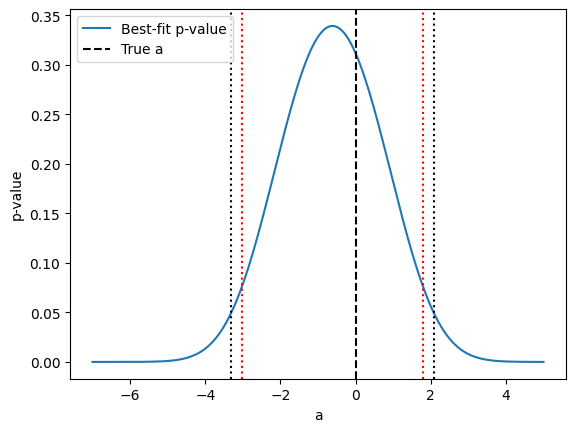

In [73]:
fig, ax = plt.subplots()
ax.plot(a_scan_grid, p_values, label="Best-fit p-value")
ax.axvline(a, color="k", linestyle="--", label="True a")
for alim in a_limits:
    ax.axvline(alim, color="k", linestyle=":")
for alim in a_peak_limits:
    ax.axvline(alim, color="r", linestyle=":")
ax.set_xlabel("a")
ax.set_ylabel("p-value")
handles, labels = ax.get_legend_handles_labels()
# ax2 = ax.twinx()
# artist = ax2.plot(a_scan_grid, chi2_values, "g")
# ax2.set_ylabel("$\\chi^2$")
# handles.append(artist[0])
# labels.append("Best-fit $\\chi^2$")
ax.legend(handles, labels)
plt.show()

# Bayesian inference and posterior marginal


In [59]:
import emcee


def logpost(theta: np.ndarray) -> float:
    a, b, c = theta
    prediction = quadratic(x_data, a, b, c)
    return -0.5 * (((prediction - y_data) / y_data_err) ** 2).sum()


n_walkers = 128
sampler = emcee.EnsembleSampler(
    nwalkers=n_walkers,
    ndim=3,
    log_prob_fn=logpost,
)

_ = sampler.run_mcmc(
    initial_state=0.1 * stats.norm.rvs(size=(n_walkers, 3)) + np.array([a, b, c]),
    nsteps=30_000,
    progress=True,
)

100%|██████████| 30000/30000 [00:26<00:00, 1128.31it/s]


In [60]:
print(f"acceptance fraction = {sampler.acceptance_fraction.mean()}")
tau = sampler.get_autocorr_time().mean()
print(f"autorocc time = {tau}")

burn_in = 10 * int(tau)
thin = 3 * int(tau)
sample: np.ndarray = sampler.get_chain(flat=True, thin=thin, discard=burn_in)
print(f"sample shape = {sample.shape}")

acceptance fraction = 0.6464875
autorocc time = 38.22070274102179
sample shape = (33152, 3)


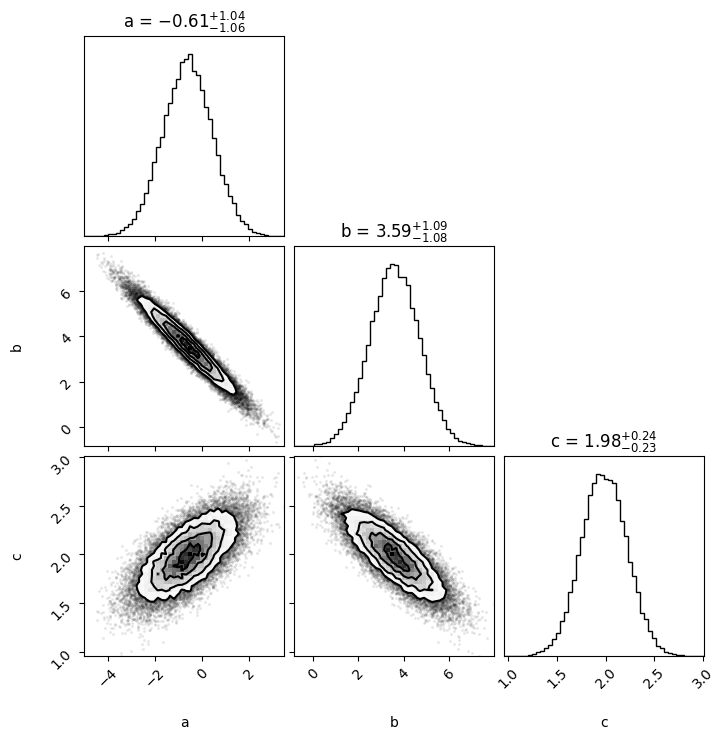

In [61]:
import corner


_ = corner.corner(sample, bins=50, labels=["a", "b", "c"], show_titles=True)

# Comparison of exclusion plots

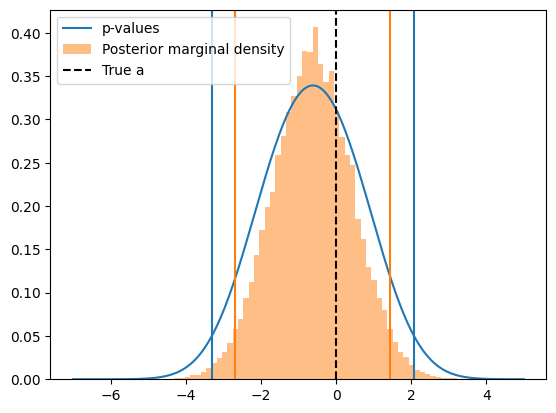

In [84]:
fig, ax = plt.subplots()

ax.plot(a_scan_grid, p_values, label="p-values")
for alim in a_limits:
    ax.axvline(alim, color="tab:blue")

ax.hist(sample[:, 0], bins=60, density=True, alpha=0.5, label="Posterior marginal density")
for q in (0.025, 0.975):
    ax.axvline(np.quantile(sample[:, 0], q=q), color="tab:orange")

ax.axvline(a, color="k", linestyle="--", label="True a")

ax.legend()
plt.show()